In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

In [37]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import joblib
from tqdm.notebook import tqdm

# Загружаем и готовим данные 

In [ ]:
df = pd.read_pickle('df_done_sub.pkl') #выборка с уже объединеными подклассами звезд 


In [6]:
df3 = df.copy()
labels = {'STAR':1, 'GALAXY':2, 'QSO':3}
df.replace({'class':labels}, inplace = True)
df.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
0,1237671256908628119,71.158077,21.333093,0.000127,0.000007,1,K3,18.60245,16.39218,15.41919,15.02712,14.80693,18.56369,16.39435,15.41744,15.03489,14.80436
1,1237662224090988683,245.087060,21.761936,-0.000114,0.000021,1,WD1,17.05462,17.11506,17.52513,17.79336,18.08322,17.04298,17.10623,17.50796,17.80872,18.10710
2,1237678439696957925,31.079203,3.429988,0.600258,0.000121,2,NaN,24.68714,22.30432,20.88555,19.98248,19.67558,24.76204,21.75368,20.48914,19.52968,19.21125
3,1237658205035823360,144.343990,42.530499,3.204911,0.000755,3,NaN,24.69678,21.42912,21.20449,21.01514,21.40008,24.90437,21.41079,21.20130,21.02791,21.41992
4,1237667113333817747,142.735950,25.753559,2.302619,0.000296,3,BROADLINE,21.99980,21.40259,21.57071,21.51316,20.84446,21.94518,21.32935,21.49114,21.23290,20.86414


Создадим дополнительную выборуку, чтобы проэксперементировать с классификаторами, отделяющие только STAR

In [7]:
df2 = df3.copy()
labels = {'STAR':0, 'GALAXY':1, 'QSO':1}
df2.replace({'class':labels}, inplace = True)
df2.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
0,1237671256908628119,71.158077,21.333093,0.000127,0.000007,0,K3,18.60245,16.39218,15.41919,15.02712,14.80693,18.56369,16.39435,15.41744,15.03489,14.80436
1,1237662224090988683,245.087060,21.761936,-0.000114,0.000021,0,WD1,17.05462,17.11506,17.52513,17.79336,18.08322,17.04298,17.10623,17.50796,17.80872,18.10710
2,1237678439696957925,31.079203,3.429988,0.600258,0.000121,1,NaN,24.68714,22.30432,20.88555,19.98248,19.67558,24.76204,21.75368,20.48914,19.52968,19.21125
3,1237658205035823360,144.343990,42.530499,3.204911,0.000755,1,NaN,24.69678,21.42912,21.20449,21.01514,21.40008,24.90437,21.41079,21.20130,21.02791,21.41992
4,1237667113333817747,142.735950,25.753559,2.302619,0.000296,1,BROADLINE,21.99980,21.40259,21.57071,21.51316,20.84446,21.94518,21.32935,21.49114,21.23290,20.86414


В оригинальной тетрадке была отмечена зависимость признаков u, g, r, i, z (в этом можно убедиться на графиках выше), поэтому было осуществлено сжатие данных признаков с помощью PCA. Я этого делать не буду, т.к. хочу получить зависимость точности классификации STAR конкретно от признака r (звездной величины).

In [9]:
df = df.sort_values(by='cModelMag_r')
df.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
3485413,1237661001056845889,156.85147,41.638954,0.364095,0.000102,2,NaN,17.14206,17.57845,17.73233,18.68621,17.40770,10.48924,10.43573,10.56004,11.62111,10.30533
4220713,1237661001056845889,156.85147,41.638954,0.290089,0.000045,2,NaN,17.14206,17.57845,17.73233,18.68621,17.40770,10.48924,10.43573,10.56004,11.62111,10.30533
2278661,1237661974938976281,190.48903,6.850845,-0.000051,0.000524,1,WD,17.50879,18.56535,18.63430,19.23723,19.02882,10.20505,10.71276,10.84706,11.03211,10.64249
751942,1237661948639772687,175.24482,11.471141,0.003304,0.000008,2,BROADLINE,17.75602,16.17859,15.55491,15.16904,14.55951,12.90137,11.70385,11.03817,10.66695,10.37867
1607931,1237663203863035998,51.70502,-0.007240,-0.000004,0.000025,1,K5,21.05164,20.39033,18.83824,18.56721,18.00602,14.23634,13.96546,11.05246,10.99057,10.27308


Data separation into features and labels

In [10]:
X = df.drop(['class','subClass'], axis = 1).values
y = df['class'].values
X.shape

(5217631, 15)

In [11]:
X2 = df2.drop(['class','subClass'], axis = 1).values
y2 = df2['class'].values
X2.shape

(5217631, 15)

Дополнительная выборка только звезд, на которой так же можно проверять точность:

Разделение данных на обучающие и тестовые

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state = 123)

In [14]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.3, random_state = 123)

In [15]:
np.unique(y_train, return_counts = True)

(array([1, 2, 3]), array([331989, 904299, 329001]))

In [16]:
np.unique(y2_test, return_counts = True)

(array([0, 1]), array([ 331361, 1233929]))

Учитывая колличество элементов в каждом значения признака class, тренировочная выборка нам подходит 

Because of presence of outliers we will be using RobustScaler to perform scaling on the data. For more about it look here:
https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf

In [17]:
X_test_not_scaling = X_test.copy()
X2_test_not_scaling = X2_test.copy()
robust = RobustScaler()
X_train = robust.fit_transform(X_train)
X_test = robust.transform(X_test)
X = robust.transform(X)
#Xs = robust.transform(Xs)
X2_train = robust.fit_transform(X2_train)
X2_test = robust.transform(X2_test)
#Xs.shape

In [ ]:
lr = joblib.load('filename.pkl')
lr2 = joblib.load('lr2.pkl')
rf = joblib.load('rf.pkl')
rf2 = joblib.load('rf2.pkl')

# Поверка на данных с измененным поглощением: 

In [33]:
coeff = {'u': 4.239, 'g': 3.303, 'r': 2.285, 'i': 1.698, 'z': 1.263} #Rv = 3.1

In [34]:
df[(df['z'] == 0) & (df['class'] == 2)].shape

(0, 17)

In [35]:
df.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
3485413,1237661001056845889,156.85147,41.638954,0.364095,0.000102,2,NaN,17.14206,17.57845,17.73233,18.68621,17.40770,10.48924,10.43573,10.56004,11.62111,10.30533
4220713,1237661001056845889,156.85147,41.638954,0.290089,0.000045,2,NaN,17.14206,17.57845,17.73233,18.68621,17.40770,10.48924,10.43573,10.56004,11.62111,10.30533
2278661,1237661974938976281,190.48903,6.850845,-0.000051,0.000524,1,WD,17.50879,18.56535,18.63430,19.23723,19.02882,10.20505,10.71276,10.84706,11.03211,10.64249
751942,1237661948639772687,175.24482,11.471141,0.003304,0.000008,2,BROADLINE,17.75602,16.17859,15.55491,15.16904,14.55951,12.90137,11.70385,11.03817,10.66695,10.37867
1607931,1237663203863035998,51.70502,-0.007240,-0.000004,0.000025,1,K5,21.05164,20.39033,18.83824,18.56721,18.00602,14.23634,13.96546,11.05246,10.99057,10.27308


In [36]:
def extinction(X, Ebv): #функция добавления поглощения к данным

    for Mag in [5, 10]:
        for i, filters in enumerate(['u', 'g', 'r', 'i', 'z']):
            X[:, Mag+i] = X[:, Mag+i] + float(Ebv * coeff[filters])
    return X


In [37]:
def Acc(Model, X_main, y, index):
    
    #train_acc = []
    test_acc = []
    #train_f1 = []
    test_f1 = []
    
    EBV = np.arange(0, 3, 0.25)
    
    for Ebv in tqdm(EBV):
        X = X_main.copy()
        X[index] = extinction(X[index], Ebv)
        X_test = robust.transform(X)
        
        #print(X_train.shape)

        #train_ans = Model.predict(X_train)
        test_ans = Model.predict(X_test)
        #train_acc.append(accuracy_score(y, train_ans))
        #train_f1.append(classification_report(y_train, train_ans, output_dict=True, zero_division=0)['1']['f1-score'])
        test_acc.append(accuracy_score(y, test_ans))
        test_f1.append(classification_report(y, test_ans, output_dict=True, zero_division=0)['1']['f1-score'])
    
    return test_acc, test_acc, test_f1, test_f1, EBV


[0.9739966275577628, 0.9737460138230434, 0.9734820427626638, 0.9732046938536001, 0.9729000331541462, 0.9726071235931276, 0.9723040979453801, 0.9720174847950586, 0.971704150578839, 0.9713600596377421, 0.9709871453201779, 0.970620615023198] [0.9739966275577628, 0.9737460138230434, 0.9734820427626638, 0.9732046938536001, 0.9729000331541462, 0.9726071235931276, 0.9723040979453801, 0.9720174847950586, 0.971704150578839, 0.9713600596377421, 0.9709871453201779, 0.970620615023198] [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75]
Best accuracy_store is 0.9630814967492092 with 0.0 Ebv


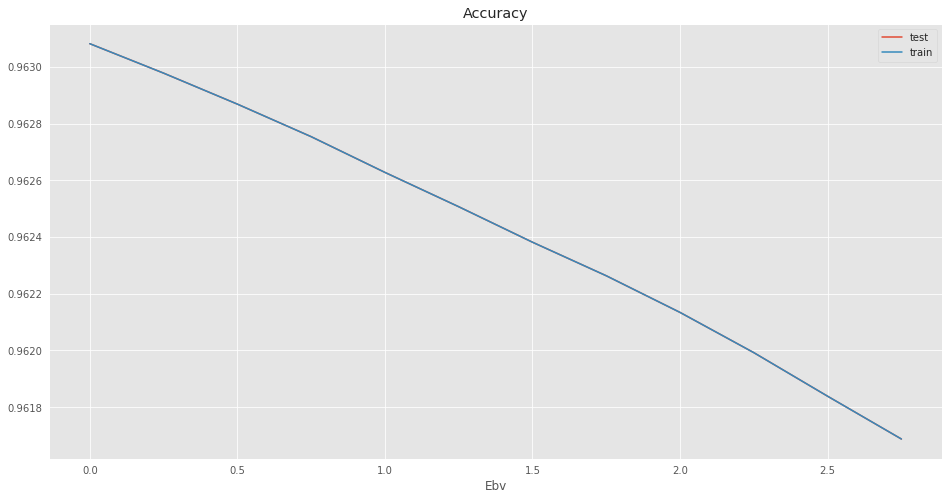

Лучший f1_score  0.9739966275577628 with 0.0 Ebv


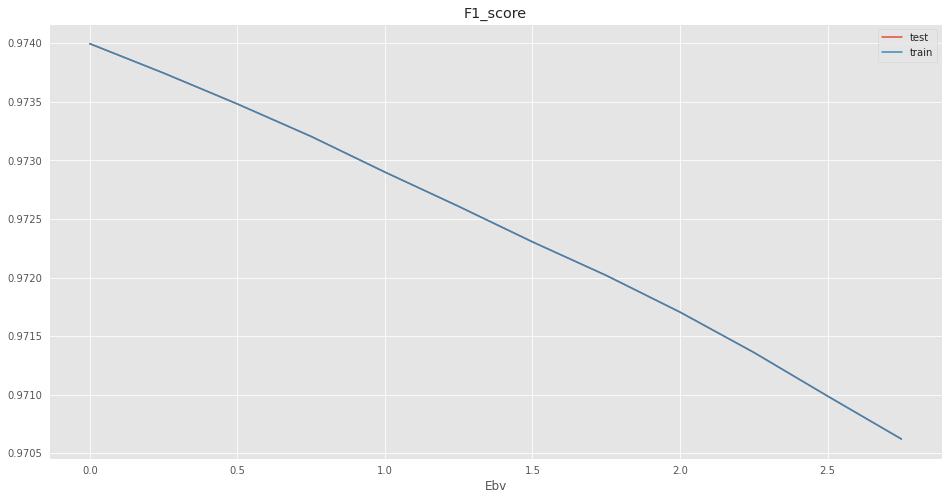

In [70]:
test_acc, train_acc, test_f1, train_f1, grid = Acc(lr, X_test_not_scaling, y_test, y_test==1) # если добавляем поглощение только к звездам
print(test_f1, train_f1, grid)
visualize(test_acc, train_acc, test_f1, train_f1, grid, "Ebv")


[0.008360714588592522, 0.007972285177915662, 0.007572194615484264, 0.007257044146167388, 0.006940665864543338, 0.006616474484789009, 0.006307482753176592, 0.005995770475050983, 0.005722376449708154, 0.005465341362993916, 0.005199363369402662, 0.004953851635668245] [0.008360714588592522, 0.007972285177915662, 0.007572194615484264, 0.007257044146167388, 0.006940665864543338, 0.006616474484789009, 0.006307482753176592, 0.005995770475050983, 0.005722376449708154, 0.005465341362993916, 0.005199363369402662, 0.004953851635668245] [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75]
Best accuracy_store is 0.00418836126213034 with 0.0 Ebv


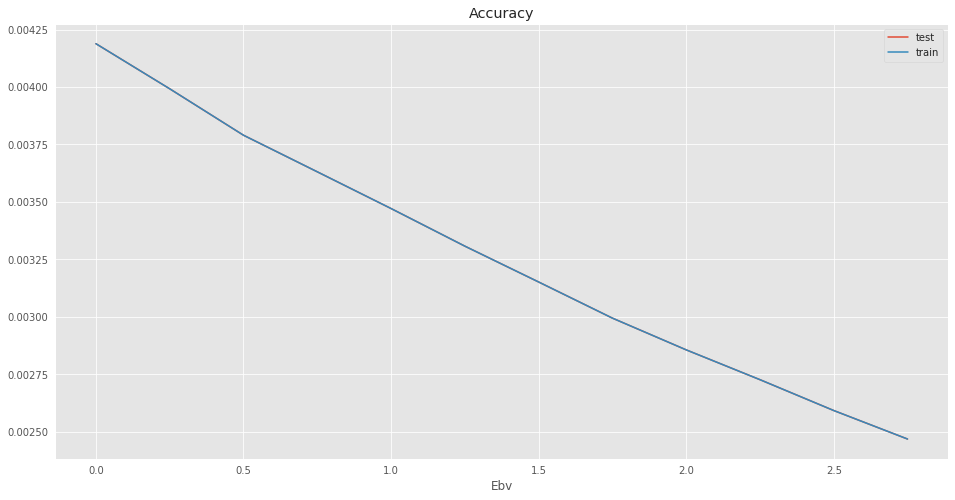

Лучший f1_score  0.008360714588592522 with 0.0 Ebv


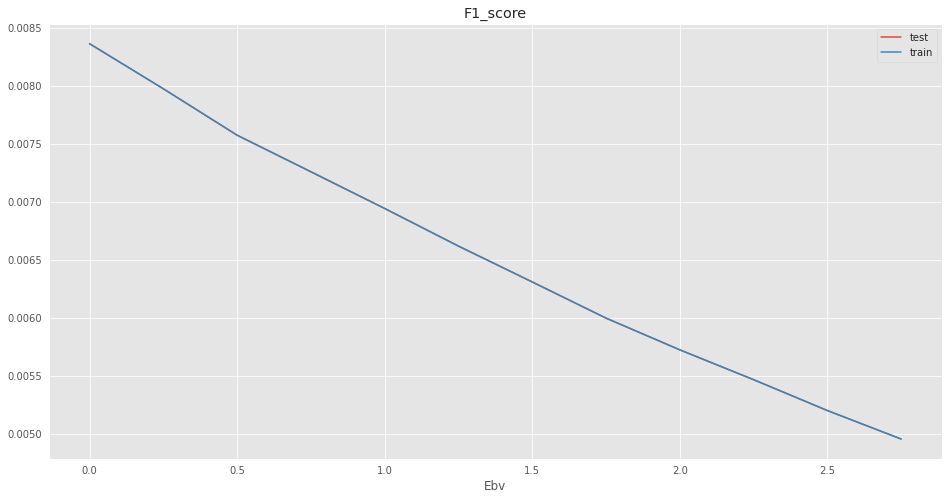

In [74]:
test_acc, train_acc, test_f1, train_f1, grid = Acc(lr2, X2_test_not_scaling, y2_test, y2_test==y2_test) 
print(test_f1, train_f1, grid)
visualize(test_acc, train_acc, test_f1, train_f1, grid, "Ebv")


[0.9978232533467885, 0.9976728422370725, 0.9974940876636037, 0.9973314814707048, 0.9972282010979867, 0.9971384311413172, 0.997076295623883, 0.9970263285341202, 0.99695364640959, 0.9968751131736744, 0.9967329794438369, 0.9964635825345232] [0.9978232533467885, 0.9976728422370725, 0.9974940876636037, 0.9973314814707048, 0.9972282010979867, 0.9971384311413172, 0.997076295623883, 0.9970263285341202, 0.99695364640959, 0.9968751131736744, 0.9967329794438369, 0.9964635825345232] [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75]
Best accuracy_store is 0.9877626465429579 with 0.0 Ebv


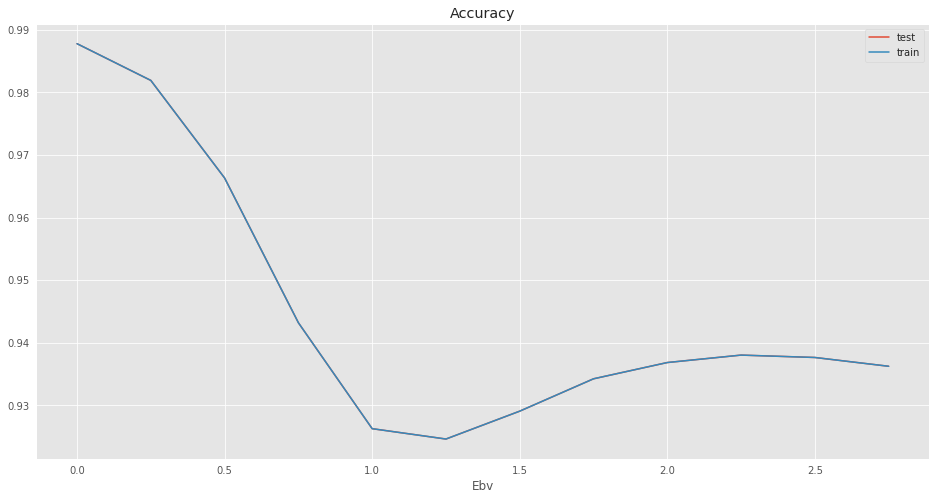

Лучший f1_score  0.9978232533467885 with 0.0 Ebv


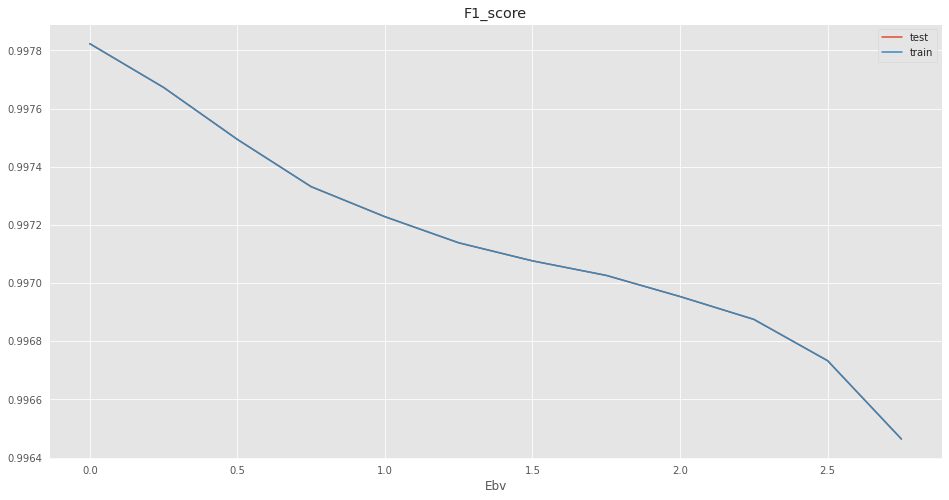

In [47]:
#dfs = df.sample(1000)
test_acc, train_acc, test_f1, train_f1, grid = Acc(rf, X_test_not_scaling, y_test, y_test==y_test)
print(test_f1, train_f1, grid)
visualize(test_acc, train_acc, test_f1, train_f1, grid, "Ebv")


[0.9978232533467885, 0.9978148255482989, 0.9978063976080613, 0.9977921346170391, 0.9977720360769721, 0.9977448045109085, 0.9977020090599846, 0.9976462398066267, 0.9975664660181988, 0.997480840996611, 0.997332259851611, 0.9970596384559413] [0.9978232533467885, 0.9978148255482989, 0.9978063976080613, 0.9977921346170391, 0.9977720360769721, 0.9977448045109085, 0.9977020090599846, 0.9976462398066267, 0.9975664660181988, 0.997480840996611, 0.997332259851611, 0.9970596384559413] [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75]
Best accuracy_store is 0.9877626465429579 with 0.0 Ebv


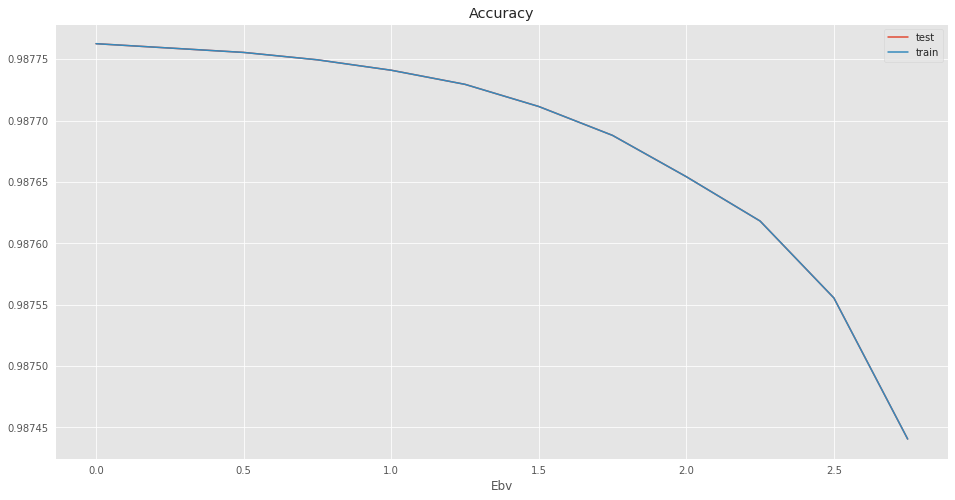

Лучший f1_score  0.9978232533467885 with 0.0 Ebv


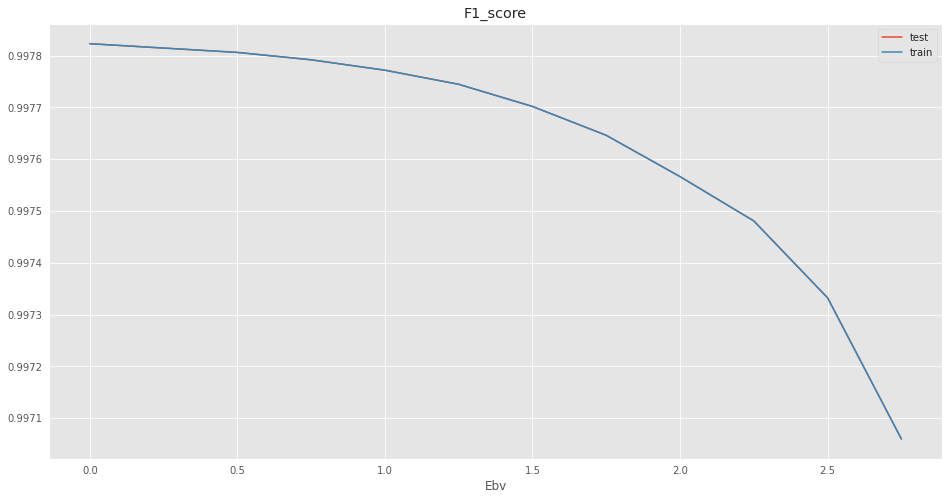

In [85]:
test_acc, train_acc, test_f1, train_f1, grid = Acc(rf, X_test_not_scaling, y_test, y_test==1)
print(test_f1, train_f1, grid)
visualize(test_acc, train_acc, test_f1, train_f1, grid, "Ebv")


[0.9995309707284386, 0.9995013552596479, 0.9994713396350946, 0.9994372679439766, 0.9994076638806731, 0.9993460573093805, 0.9992872971046748, 0.9992358499476852, 0.9990394233621965, 0.9986006937382867, 0.997840312679004, 0.9964869670114478] [0.9995309707284386, 0.9995013552596479, 0.9994713396350946, 0.9994372679439766, 0.9994076638806731, 0.9993460573093805, 0.9992872971046748, 0.9992358499476852, 0.9990394233621965, 0.9986006937382867, 0.997840312679004, 0.9964869670114478] [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75]
Best accuracy_store is 0.9992608398443739 with 0.0 Ebv


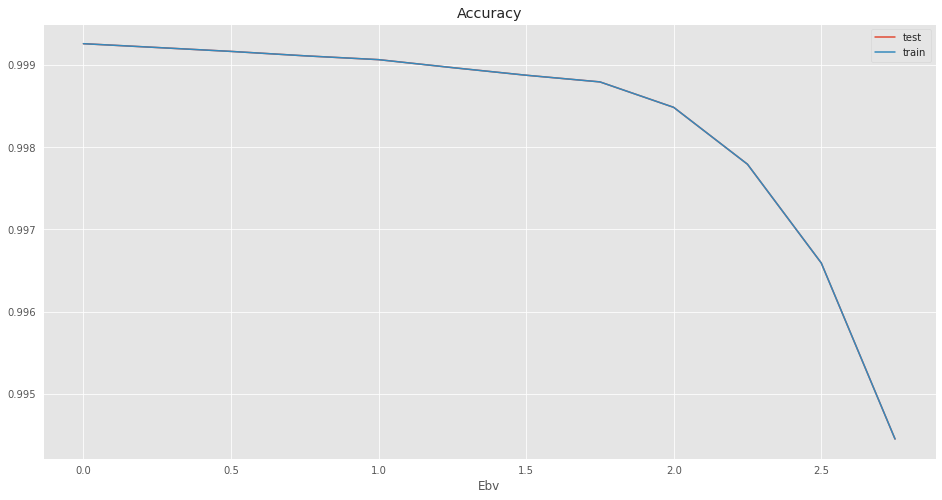

Лучший f1_score  0.9995309707284386 with 0.0 Ebv


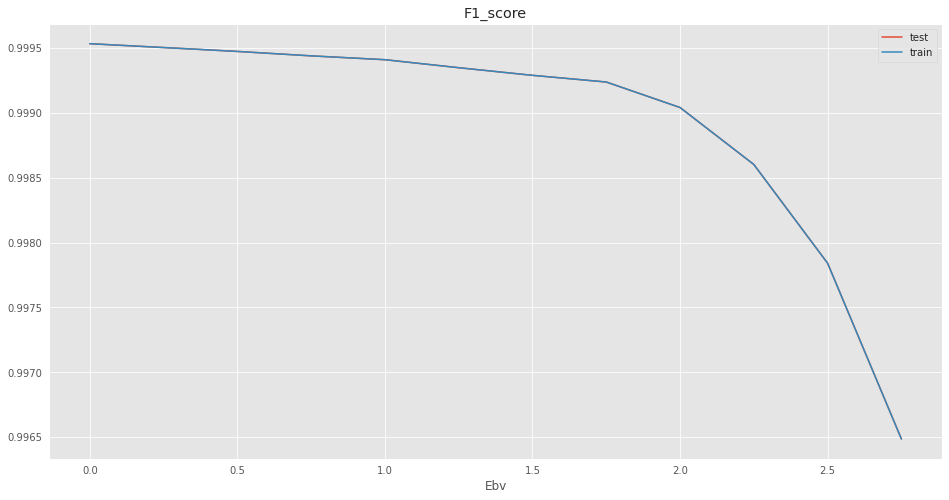

In [86]:
test_acc, train_acc, test_f1, train_f1, grid = Acc(rf2, X2_test_not_scaling, y2_test, y2_test==y2_test)
print(test_f1, train_f1, grid)
visualize(test_acc, train_acc, test_f1, train_f1, grid, "Ebv")